<a href="https://colab.research.google.com/github/suhacker1/SecureML_Tests/blob/master/Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stealing Machine Learning Models via Prediction APIs 

## Create Victim Model

In [0]:
!pip install pytorch-lightning

In [0]:
import os
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import pytorch_lightning as pl

In [0]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [0]:
batch_size = 64
num_workers = 4
learning_rate = 1e-3
rand_split_val = [55000, 5000]
gpus = 1
max_epochs = 13

In [0]:
class LightningMNISTClassifier(pl.LightningModule):
  def __init__(self):
    """Defines a three layer fully connected neural network"""
    super(LightningMNISTClassifier, self).__init__()

    # Input images are (1, 28, 28)
    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
    """Establishes the neural network's forward pass
    
    Args: 
        x (Torch tensor): MNIST input image

    Returns:
        x (Torch tensor): output probability vector for MNIST classes
    """
    batch_size, channels, width, height = x.size()

    # Input Layer: (batch_size, 1, 28, 28) -> (batch_size, 1*28*28)
    x = x.view(batch_size, -1)

    # Layer 1: (batch_size, 1*28*28) -> (batch_size, 128)
    x = self.layer_1(x)
    x = torch.relu(x)

    # Layer 2: (batch_size, 128) -> (batch_size, 256)
    x = self.layer_2(x)
    x = torch.relu(x)

    # Layer 3: (batch_size, 256) -> (batch_size, 10)
    x = self.layer_3(x)

    x = torch.log_softmax(x, dim=1)
    return x

  def cross_entropy_loss(self, logits, labels):
    """Calculates loss- the difference between model predictions and true labels
    
    Args:
        logits (Torch tensor): model output predictions
        labels (Torch tensor): true values for predictions
    """
    return F.cross_entropy(logits, labels)

  def training_step(self, train_batch, batch_idx):
    """Pushes training data batch through model and calculates loss in loop

    Args: 
        train_batch (Torch tensor): batch of training data from training dataloader 
        batch_idx (int): index of batch in contention

    Returns: 
        Formatted string with cross entropy loss and training logs
    """
    x, y = train_batch
    logits = self.forward(x)
    loss = self.cross_entropy_loss(logits, y)

    logs = {'train_loss': loss}
    return {'loss': loss, 'log': logs}

  def validation_step(self, val_batch, batch_idx):
    """Pushes validation data batch through model and calculates loss in loop

    Args: 
        val_batch (Tensor): batch of validation data from validation dataloader 
        batch_idx (int): index of batch in contention

    Returns: 
        Formatted string with resultant cross entropy loss 
    """
    x, y = val_batch
    logits = self.forward(x)
    loss = self.cross_entropy_loss(logits, y)
    return {'val_loss': loss}

  def validation_epoch_end(self, outputs):
    """Returns validation step results at the end of the epoch

    Args: 
        outputs (array): result of validation step for each batch 

    Returns: 
        Formatted string with resultant metrics
    """
    avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    tensorboard_logs = {'val_loss': avg_loss}
    return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

  def prepare_data(self):
    """Applies transformations and splits the dataset"""
    transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.1307,), (0.3081,))])
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    self.mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    self.mnist_train, self.mnist_val = random_split(mnist_train, rand_split_val)

  def train_dataloader(self):
    """Creates PyTorch dataloader for training data"""
    return DataLoader(self.mnist_train, batch_size=batch_size, num_workers=num_workers)

  def val_dataloader(self):
    """Creates PyTorch dataloader for validation data"""
    return DataLoader(self.mnist_val, batch_size=batch_size, num_workers=num_workers)

  def test_dataloader(self):
    """Creates PyTorch dataloader for test data"""
    return DataLoader(self.mnist_test, batch_size=batch_size, num_workers=num_workers)

  def configure_optimizers(self):
    """Sets up the optimization scheme"""
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    return optimizer
    
  def test_step(self, batch, batch_idx):
    """Pushes test data into the model and returns relevant metrics
    
    Args:
        batch (Torch tensor): batch of test data from test dataloader 
        batch_idx (int): index of batch in contention

    Returns:
        Formatted string with relevant metrics
    """
    x, y = batch
    y_hat = self(x)
    return {'test_loss': F.cross_entropy(y_hat, y)}

  def test_epoch_end(self, outputs):
    """Returns test step results at the end of the epoch

    Args: 
        outputs (array): result of test step for each batch 

    Returns: 
        Formatted string with resultant metrics
    """
    avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    tensorboard_logs = {'test_loss': avg_loss}
    return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}


In [0]:
def train(classifier, num_gpus, num_epochs):
    """Trains and tests the classifier 

    Args: 
        classifier (pl.LightningModule): to be trained and tested
        num_gpus (int): how many gpus are to be used 
        num_epochs (int): maximum number of epochs to train the model 
    
    Returns: 
        model (pl.LightningModule): post-training-and-testing
    """
    model = classifier()
    trainer = pl.Trainer(gpus=num_gpus, max_epochs=num_epochs)
    trainer.fit(model)
    trainer.test()
    return model

In [0]:
mnist_model = train(LightningMNISTClassifier, gpus, max_epochs)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33 K  
2 | layer_3 | Linear | 2 K   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.1244, device='cuda:0'),
 'test_loss': tensor(0.1244, device='cuda:0')}
--------------------------------------------------------------------------------



In [0]:
def convert_to_inference(model):
    """Allows a model to be used in an inference setting"""
    model.freeze()
    model.eval()
    model.cuda()
    return model

In [0]:
mnist_model = convert_to_inference(mnist_model)

In [0]:
def get_test_data(model):
    """Returns test data for a model"""
    dataset = model.mnist_test
    return dataset

def show_test_image(model, dataset, idx):
    """Shows a single image from the test dataset"""
    x, y = dataset[idx]
    plt.imshow(x.numpy()[0], cmap='gray')
    return x

In [0]:
test_data = get_test_data(mnist_model)

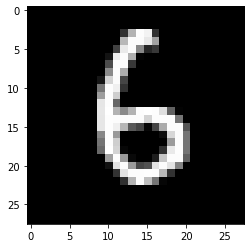

In [0]:
sample_image = show_test_image(mnist_model, test_data, 21)

In [0]:
def query_model(model, image):
    """Returns the predictions of a model given an image
    
    Args: 
        model(pl.LightningModule): model to be queried 
        image (Numpy Array): input MNIST image 

    Returns: 
        prediction (Torch tensor): output with class probabilities 
        np_prediction (Numpy Array): output with class probabilities 
        label (int): model's top choice for class shown in image
    """
    image = image.cuda()
    image = image.resize_(1, 28, 28, 1)
    prediction = model(image)
    np_prediction = prediction.cpu().numpy()
    label = np.argmax(np_prediction)
    print("The image is of the number", label, "\n")
    return prediction, np_prediction, label

In [0]:
pred_x, np_pred_x, label_x = query_model(mnist_model, sample_image)

The image is of the number 6 



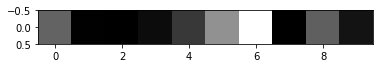

In [0]:
#Show plot of class probabilities; lighter is more accurate
plt.imshow(np_pred_x, cmap='gray')